In [1]:
# 📦 STEP 1: Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
# 📂 STEP 2: Load Data
df = pd.read_csv("Year Order Item Data.csv", parse_dates=['date'])
df.head()

,restaurant_name,invoice_no,date,payment_type,order_type,status,area,virtual_brand_name,brand_grouping,assign_to,customer_phone,customer_name,customer_address,persons,order_cancel_reason,my_amount,total_tax,discount,delivery_charge,container_charge,service_charge,additional_charge,waived_off,round_off,total,item_name,category_name,sap_code,item_price,item_quantity,item_total
0,Makers of Milkshakes - Prozone Mall,1,2024-04-01 11:32:59,Cash,Pick Up,Success,Parcel,NaN,Offline Menu,NaN,8.390407e+09,slma saphir,NaN,NaN,NaN,344.23,30.78,0.0,0,0,0,0,0,-0.01,375,Strawberry Shake (Milkshake),Classic Shakes,NaN,160.64,1,160.64
1,Makers of Milkshakes - Prozone Mall,1,2024-04-01 11:32:59,Cash,Pick Up,Success,Parcel,NaN,Offline Menu,NaN,8.390407e+09,slma saphir,NaN,NaN,NaN,344.23,30.78,0.0,0,0,0,0,0,-0.01,375,Chocolate Shake (Milkshake),Instashakes,NaN,183.59,1,183.59
2,Makers of Milkshakes - Prozone Mall,2,2024-04-01 12:05:34,Cash,Pick Up,Success,Parcel,NaN,Offline Menu,NaN,9.373995e+09,rahat khan,NaN,NaN,NaN,137.69,12.30,0.0,0,0,0,0,0,0.01,150,Classic Lemonade,Coolers,NaN,137.69,1,137.69
3,Makers of Milkshakes - Prozone Mall,3,2024-04-01 12:12:00,Cash,Pick Up,Success,Parcel,NaN,Offline Menu,NaN,8.149381e+09,sania khan,NaN,NaN,NaN,367.18,32.82,0.0,0,0,0,0,0,0.00,400,Waffles,Waffles,NaN,183.59,2,367.18
4,Makers of Milkshakes - Prozone Mall,4,2024-04-01 12:13:51,Other [UPI],Pick Up,Success,Parcel,NaN,Offline Menu,NaN,9.156525e+09,pawna mothkuwan,NaN,NaN,NaN,367.18,32.82,0.0,0,0,0,0,0,0.00,400,Banana Shake (Milkshake),Fruit Walker,NaN,183.59,1,183.59


In [3]:
# 🧹 STEP 3: Clean Data
df = df[df['order_type'] != "Delivery(Parcel)"].copy()

numeric_cols = [
    'my_amount', 'total_tax', 'discount', 'delivery_charge',
    'container_charge', 'service_charge', 'additional_charge',
    'waived_off', 'round_off', 'total', 'item_price', 'item_quantity', 'item_total'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[['discount', 'waived_off']] = df[['discount', 'waived_off']].fillna(0)
df.dropna(subset=['invoice_no', 'item_name', 'item_quantity', 'item_total'], inplace=True)

df['net_sales'] = df['item_total'] - df[['discount', 'waived_off']].sum(axis=1)
df['YearMonth'] = df['date'].dt.to_period('M')
df['DateOnly'] = df['date'].dt.date
df['Weekday'] = df['date'].dt.day_name()
df['Hour'] = df['date'].dt.hour

In [4]:
# 🧮 STEP 4: Invoice-Level Aggregation
invoice_kpis = (
    df.groupby('invoice_no').agg(
        order_date=('date', 'min'),
        total_unique_items=('item_name', 'nunique'),
        total_quantity=('item_quantity', 'sum'),
        total_discount=('discount', 'sum'),
        total_waived_off=('waived_off', 'sum'),
        net_invoice_value=('net_sales', 'sum')
    ).reset_index()
)

invoice_kpis['order_day'] = invoice_kpis['order_date'].dt.day_name()
invoice_kpis['order_hour'] = invoice_kpis['order_date'].dt.hour

invoice_kpis.to_csv("../results/order_analysis/Invoice_Aggregation.csv", index=False)

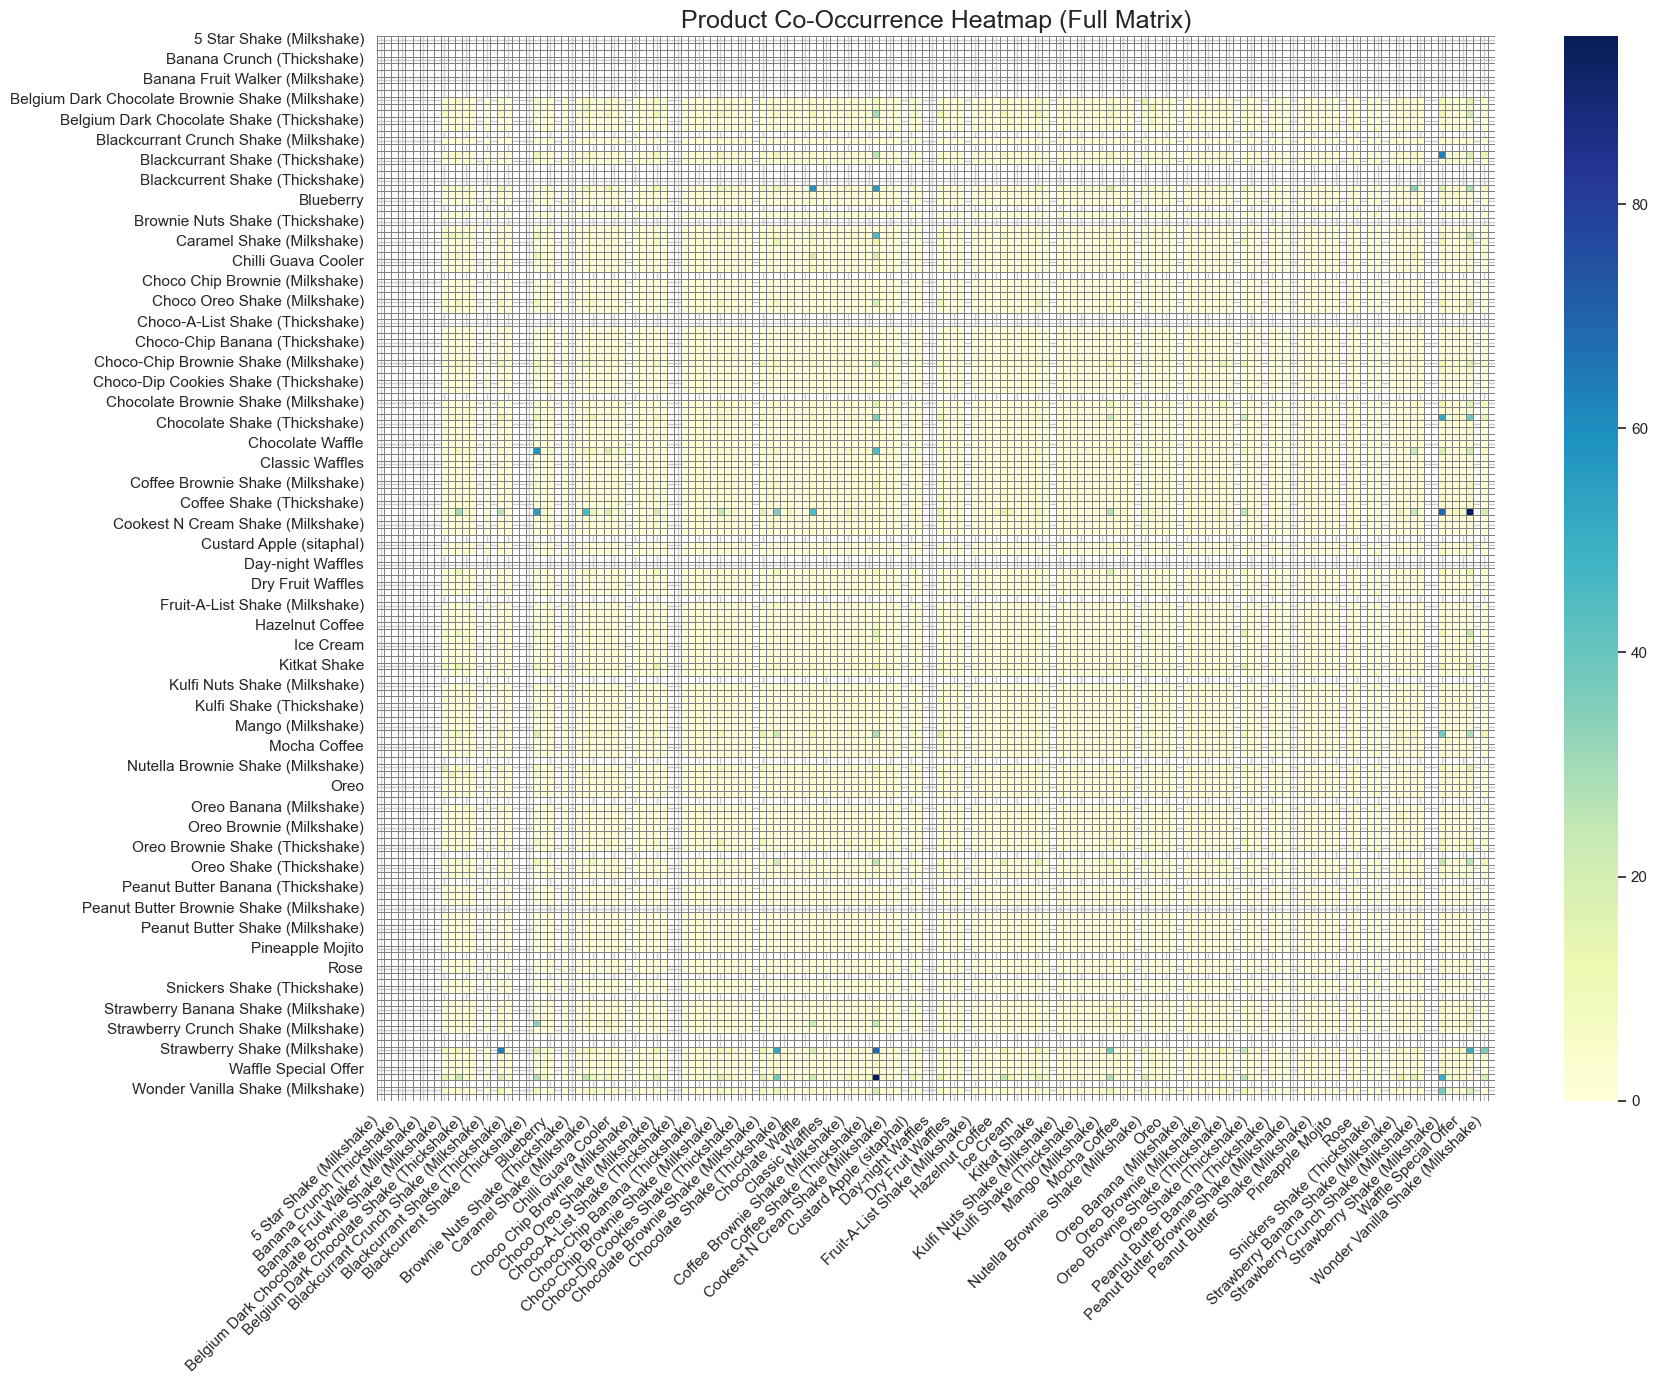

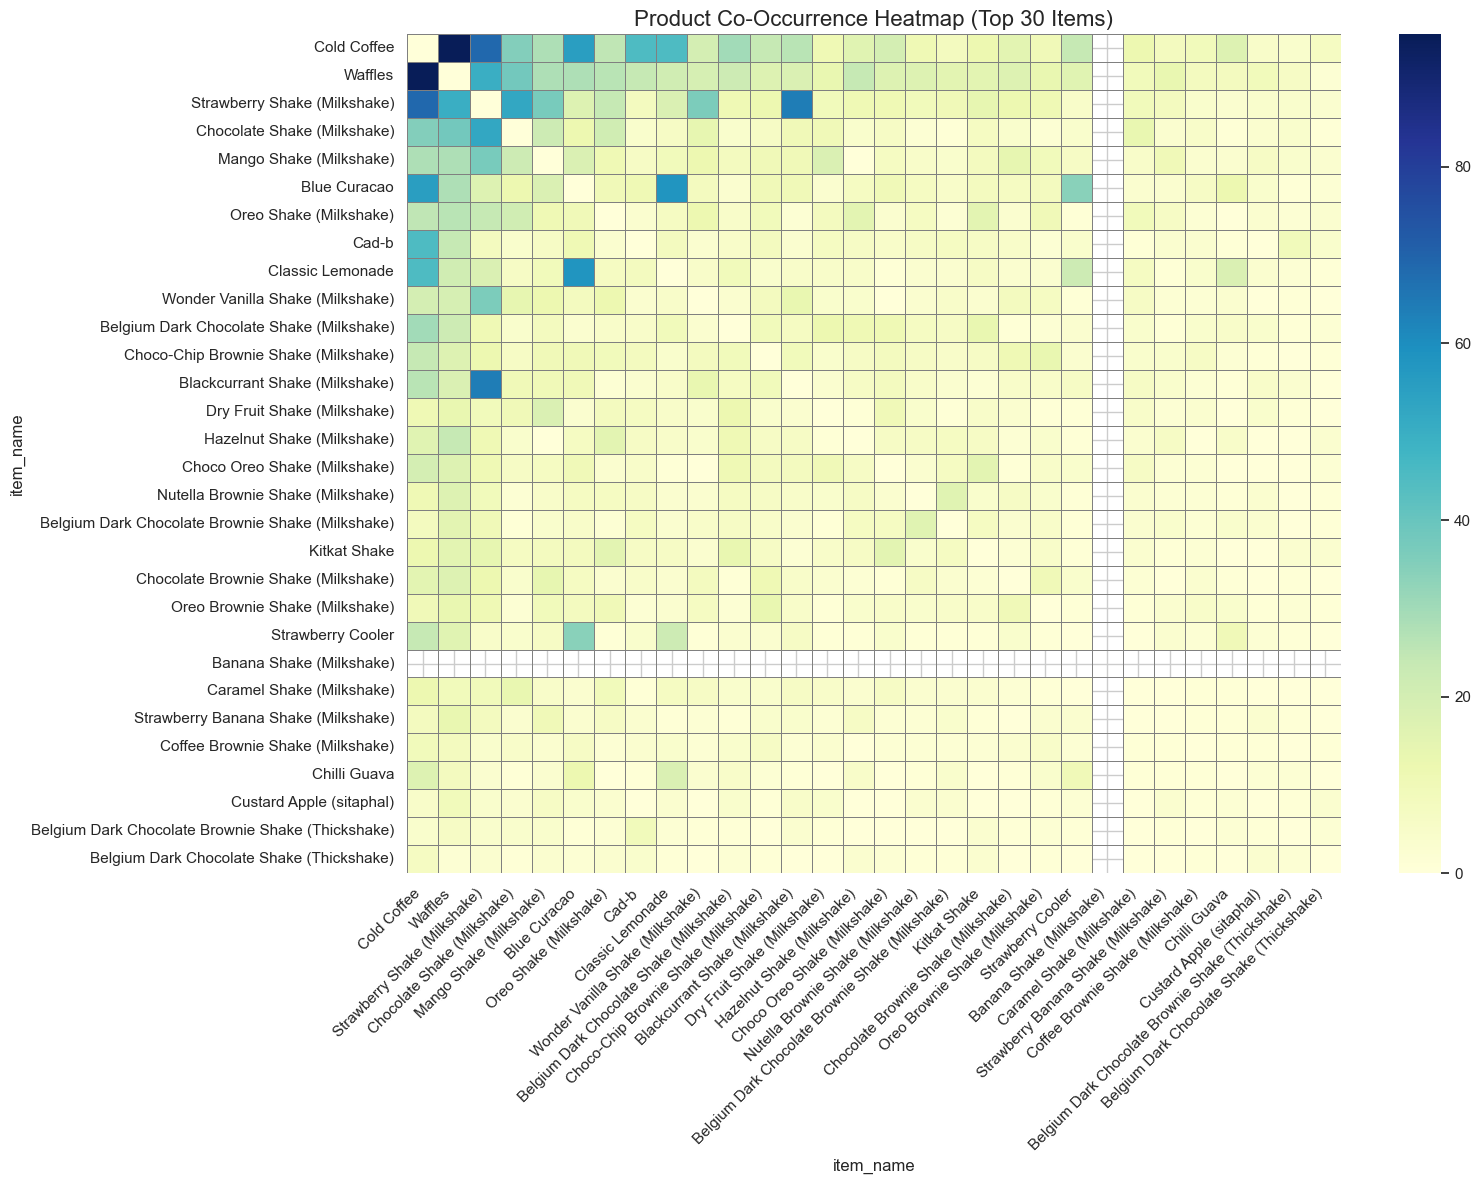

In [5]:
# 🤝 STEP 5: Product Co-Occurrence Matrix
invoice_items = df.groupby('invoice_no')['item_name'].apply(list).reset_index()
invoice_items['basket_size'] = invoice_items['item_name'].apply(lambda x: len(set(x)))
invoice_items.head()

# Build pair counts
def build_pair_counter(item_lists):
    pair_counter = Counter()
    for items in item_lists:
        unique_items = list(set(items))
        if len(unique_items) > 1:
            pairs = combinations(sorted(unique_items), 2)
            pair_counter.update(pairs)
    return pair_counter

pair_counter = build_pair_counter(invoice_items['item_name'])
co_occurrence_df = pd.DataFrame(pair_counter.items(), columns=['item_pair', 'count'])
co_occurrence_df[['item_1', 'item_2']] = pd.DataFrame(co_occurrence_df['item_pair'].tolist(), index=co_occurrence_df.index)
co_occurrence_df.drop(columns='item_pair', inplace=True)
co_occurrence_df.sort_values(by='count', ascending=False, inplace=True)

# Symmetric matrix
matrix_df = pd.pivot_table(
    co_occurrence_df,
    values='count',
    index='item_1',
    columns='item_2',
    fill_value=0
)
full_matrix = matrix_df + matrix_df.T.fillna(0)

# Heatmaps
plt.figure(figsize=(18, 14))
sns.heatmap(full_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title("Product Co-Occurrence Heatmap (Full Matrix)", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.show()

top_items = df['item_name'].value_counts().head(30).index
filtered_matrix = full_matrix.loc[top_items, top_items]

plt.figure(figsize=(16, 12))
sns.heatmap(filtered_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title("Product Co-Occurrence Heatmap (Top 30 Items)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

filtered_matrix.to_csv("../results/order_analysis/Product_Co_occurrence_Top30.csv")